# Hyperparameter analysis in Manna model

The purpose of this notebook is to find out the effect of hyperparameter $a$ on the quality of predictions. Obviously, the larger hyperparameter $a$ means the larger the memory in AR(1) process. 

Let's calculate time when the forecast will contribute less than 1 to the decision variable:

$$ a^n \cdot s < 1$$

Under the assumption $a(L) = e^{-\frac{1}{T(L)}}$:

$$ e^{-\frac{n}{T(L)}} < 1 $$

Consequently:

$$ n > \ln s \cdot T(L) $$

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")

import sys
sys.path.insert(1, 'src/')

In [2]:
import abel_heap
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (10,10)
plt.rcParams['font.size'] = 36
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['xtick.minor.pad'] = 15
plt.rcParams['xtick.major.pad'] = 15
plt.rcParams['ytick.minor.pad'] = 15
plt.rcParams['ytick.major.pad'] = 15

## Scaling

By the fixed $p$ and $\gamma$:

$$ \eta = p \cdot L^{\gamma} $$

Predict probability of:

$$ s_i > \eta $$

In [3]:
def plot_global_auc_curves(auc_curve, gamma, ax=None, legend=True):
    sns.lineplot(data=auc_curve, x="T", y="eps", hue="L", style="p", markers=True, palette="tab10", markersize=10, ax=ax)
    str_gamma = "{" + f"{gamma:.3}" + "}"
    if ax is None:
        #plt.title("Quality of predictions, $\gamma=$" + str(gamma))
        plt.xlabel("T")
        plt.ylabel("$\epsilon$")
        plt.xscale("log")
        if legend:
            plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
    else:
        #ax.set_title("Quality of predictions, $\gamma=$" + str(gamma))
        ax.set_xlabel("T")
        ax.set_ylabel("$\epsilon$")
        ax.set_xscale("log")
        if legend:
            ax.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)

In [4]:
def calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, model, njobs=-1):
    # build args
    get_eta = lambda L, percent: int(L**gamma * percent)
    get_a = lambda T: np.exp(-1. / T)
    
    args = []
    add_t = []
    add_p = []
    add_gamma = []

    for L in LS:
        for T in TS:
            A = get_a(T)
            for percent in PERCENTS_ETA:
                ETA = get_eta(L, percent)
                
                add_t.append(T)
                add_p.append(percent)
                add_gamma.append(gamma)
                args.append((L, ETA, A, model))
    
    # run subprograms
    abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)
    auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=njobs)

    # calculate some useful columns
    auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)
    auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
    auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
    auc_curve["T"] = add_t
    auc_curve["p"] = add_p
    auc_curve["gamma"] = add_gamma
    
    return auc_curve

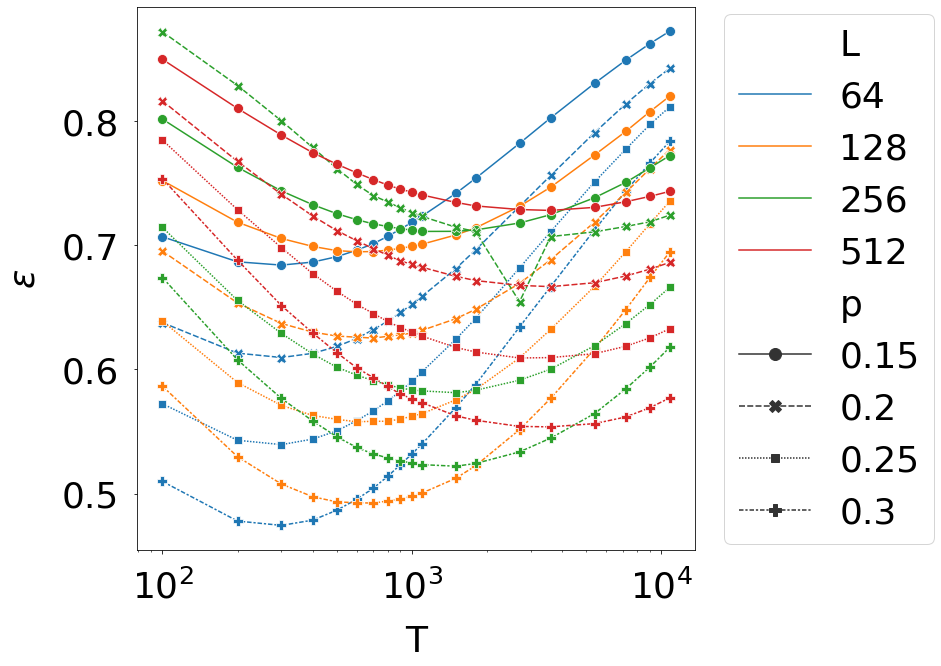

In [5]:
gamma = 2.55

PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
LS = [64, 128, 256, 512]
TS = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

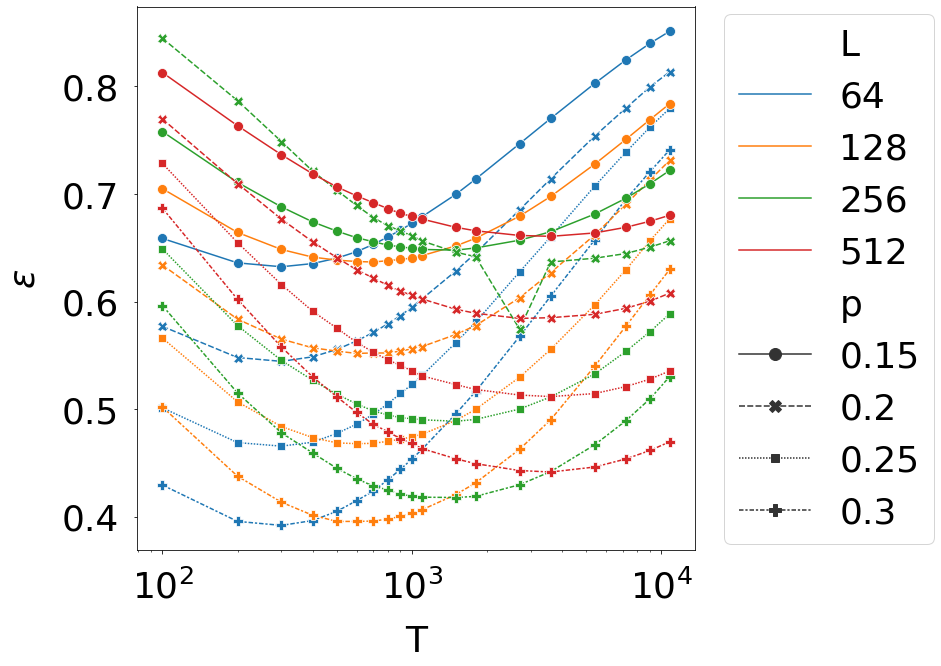

In [6]:
gamma = 2.6

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

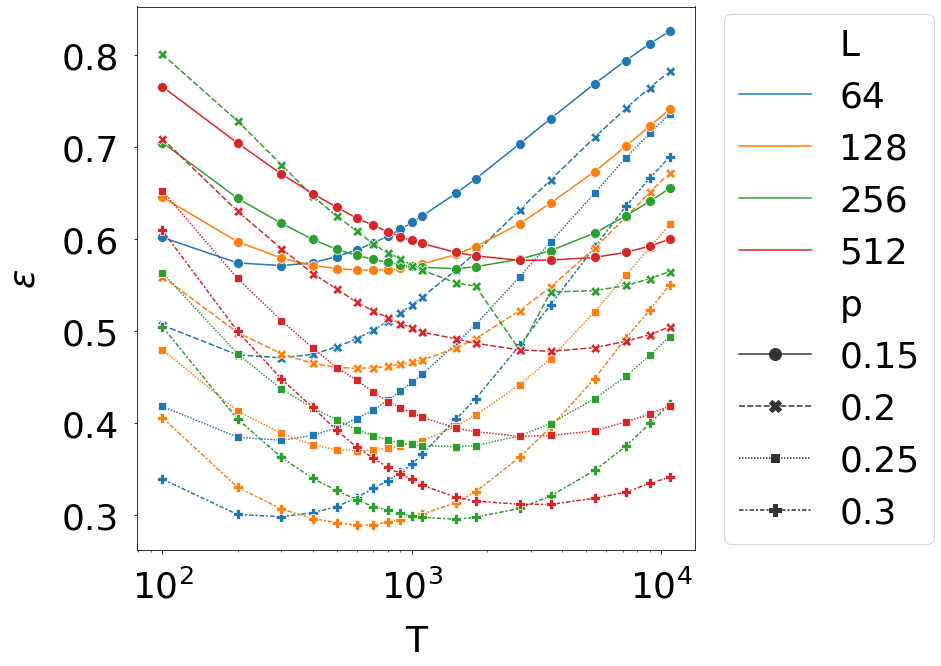

In [7]:
gamma = 2.65

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

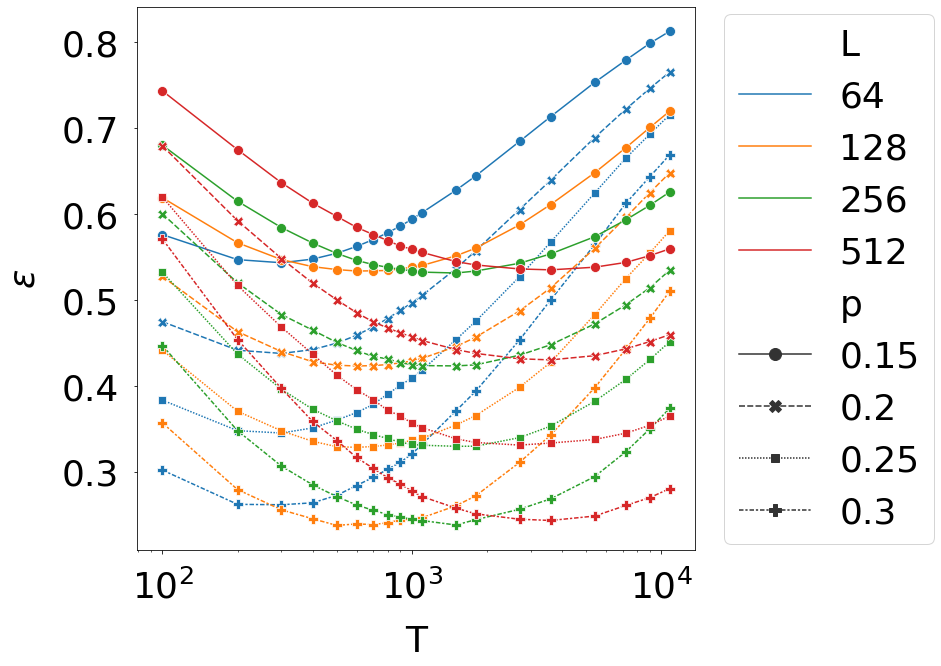

In [8]:
gamma = 2.67

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

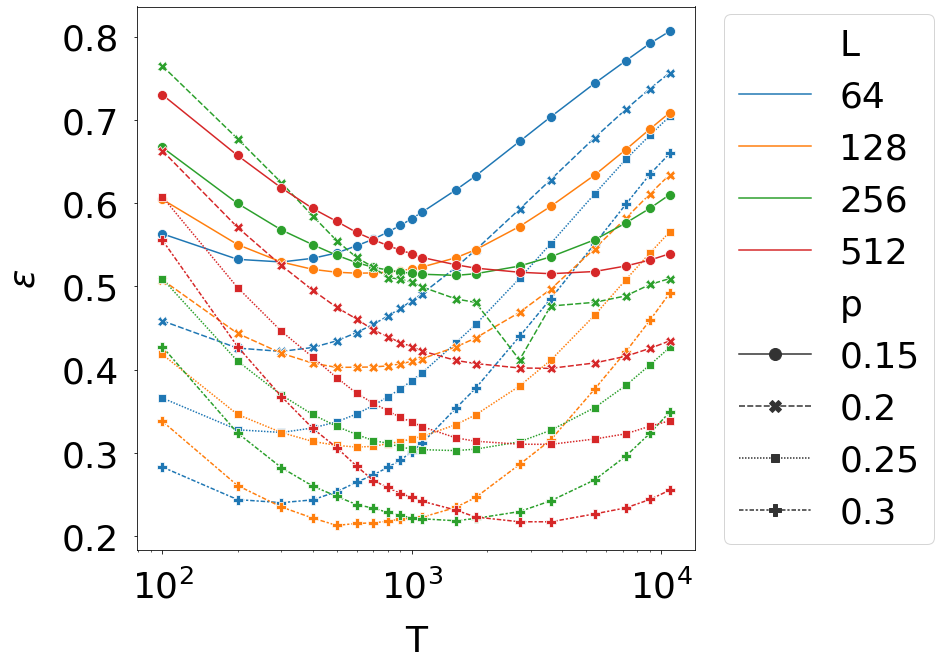

In [9]:
gamma = 2.68

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

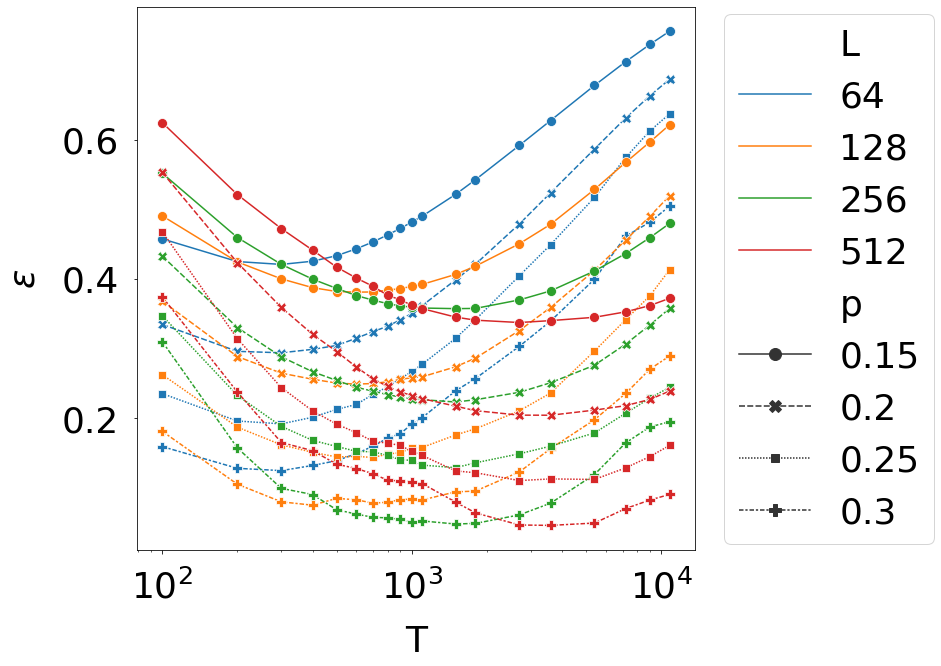

In [11]:
gamma = 2.75

auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
plot_global_auc_curves(auc_curve, gamma)

## Find an optimal T(L)

Let's see on the optimal $T(L)$ for different $\gamma$

In [12]:
def plot_auc_curve(auc_curve, ax=None):
    plt_ax = ax or plt
    used = set()

    for _, row in auc_curve.iterrows():
        L = row["L"]
        ETA = row["ETA"]
        A = row["A"]

        if L == 64:
            marker = "|"
            linestyle = "solid"
        elif L == 128:
            marker = "*"
            linestyle = "dotted"
        elif L == 256:
            marker = "x"
            linestyle = "dashed"
        else:
            marker = "1"
            linestyle = "-."

        if L in used:
            label = None
        else:
            label = f"L={L}"
            used.add(L)

        fpr, tpr, thresholds = row["results"]

        plt_ax.plot(fpr, tpr, marker=marker, linestyle=linestyle, color="black", linewidth=1, markersize=10, alpha=0.7, label=label)

    if ax is not None:
        plt_ax.set_title(r"ROC curves, $\gamma=$" + str(gamma))
        plt_ax.set_xlim(0, 1)
        plt_ax.set_ylim(0, 1)
        plt_ax.set_xlabel("False Positive Rate")
        plt_ax.set_ylabel("True Positive Rate")
        plt_ax.legend(markerscale=2)
    else:
        plt_ax.title(r"ROC curves, $\gamma=$" + str(gamma))
        plt_ax.xlim(0, 1)
        plt_ax.ylim(0, 1)
        plt_ax.xlabel("False Positive Rate")
        plt_ax.ylabel("True Positive Rate")
        plt_ax.legend(markerscale=2)

In [13]:
def plot_auc_curve(auc_curve, ax=None):
    exploded = auc_curve.explode("fpr", ignore_index=True).drop(columns=["results", "tpr"])
    exploded["tpr"] = auc_curve["tpr"].explode(ignore_index=True)
    exploded["fpr"] = exploded["fpr"].astype(float)
    exploded["tpr"] = exploded["tpr"].astype(float)
    
    sns.lineplot(data=exploded[::5], x="fpr", y="tpr", hue="L", style="p", markers=True, palette="tab10", markersize=10, legend=False, ax=ax)
    if ax is not None:
        #ax.set_title(r"ROC curves, $\gamma=$" + str(gamma))
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        #plt.legend(markerscale=2)
    else:
        #plt.title(r"ROC curves, $\gamma=$" + str(gamma))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        #plt.legend(markerscale=2)

In [14]:
def plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, model):
    local_aucs = []

    for i, L in enumerate(LS):
        TS_local_scaled = [int(t_scaling**i * t) for t in TS_local]
        auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, [L], TS_local_scaled, model, njobs=7)
        local_aucs.append(auc_curve)

    local_auc_curves = pd.concat(local_aucs)

    global_auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS_global, model, njobs=7)
    best_aucs = global_auc_curve.iloc[global_auc_curve.groupby(["L", "p"])["eps"].idxmin()]
    
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    #fig.subplots_adjust(wspace=0.3)
    #plot_auc_curve(best_aucs, ax1)
    #plot_global_auc_curves(global_auc_curve, gamma, ax2)
    plot_auc_curve(best_aucs)
    plt.show()
    plot_global_auc_curves(global_auc_curve, gamma)
    plt.show()

    ax = sns.relplot(data=local_auc_curves, x="T", y="eps", style="p", hue="L", markers=True, palette="tab10", markersize=10, col="L", 
                     kind="line", facet_kws={'sharey': True, 'sharex': False})
    plt.suptitle("T(L) near to local minimum", y=1.1)
    ax.set_axis_labels("T(L)", "$\epsilon$")
    ax._legend.set_bbox_to_anchor([1.02, 0.61])
    ax._legend.set_frame_on(True)
    plt.show()

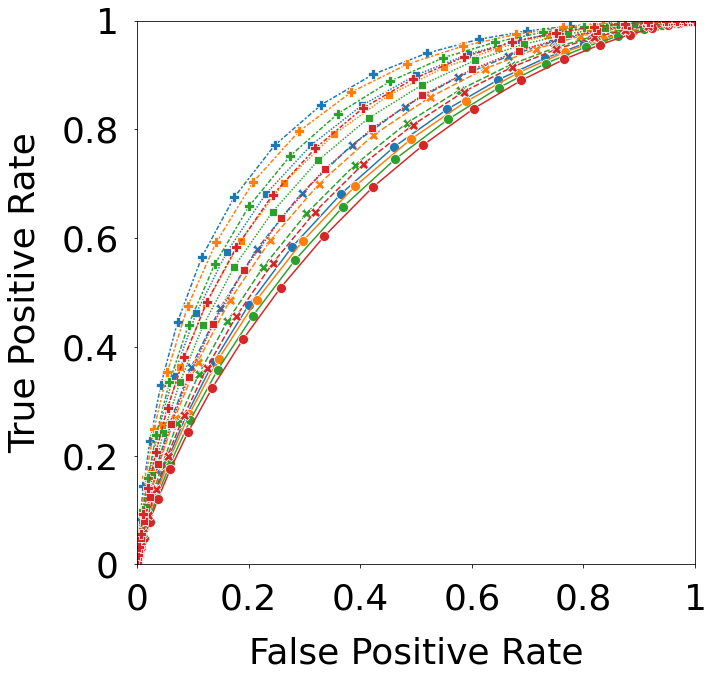

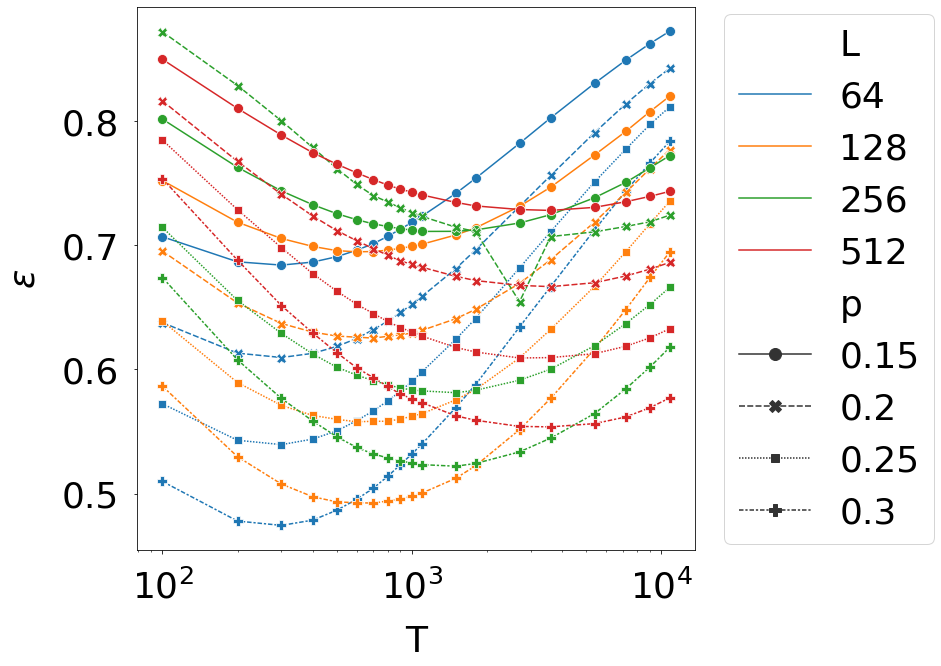

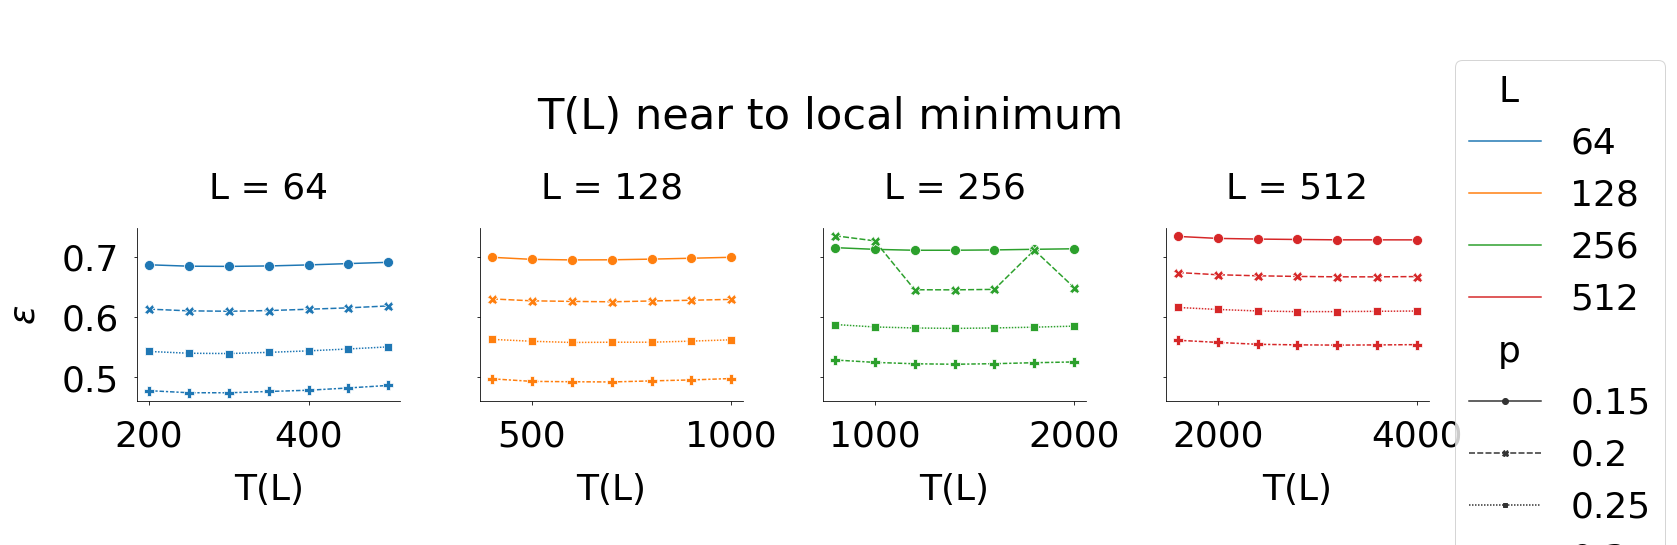

In [15]:
gamma = 2.55
t_scaling = 2

LS = [64, 128, 256, 512]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
TS_local = [200, 250, 300, 350, 400, 450, 500]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

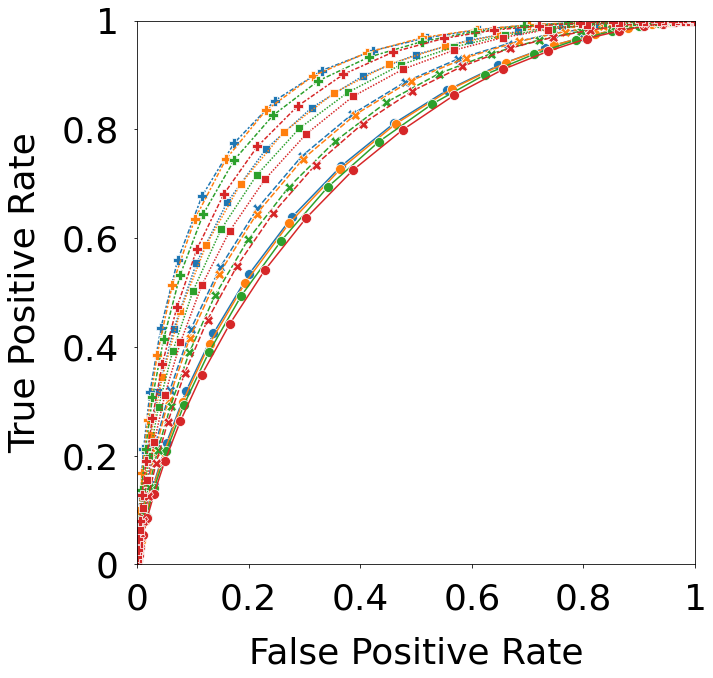

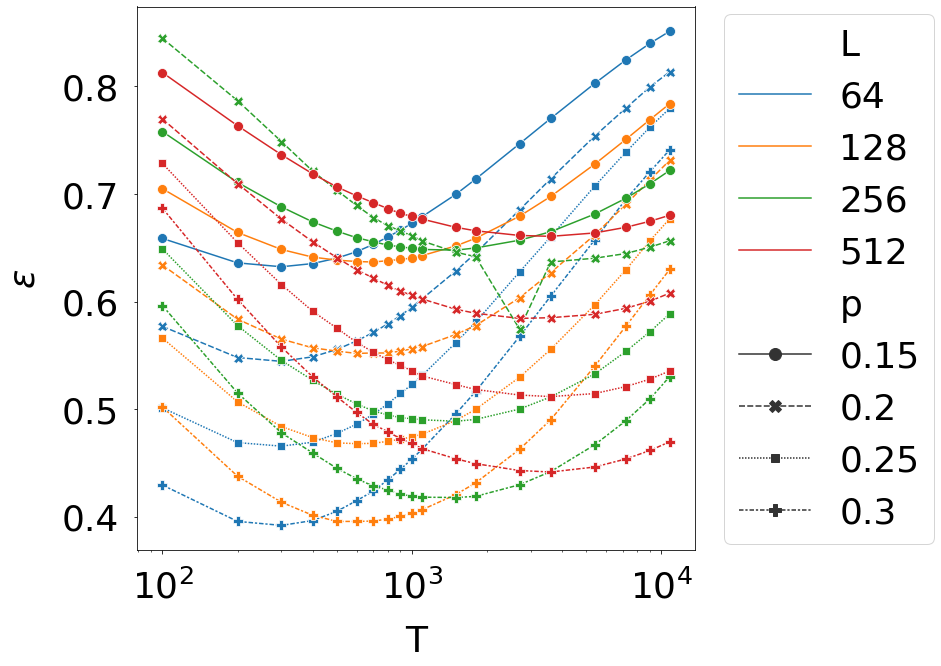

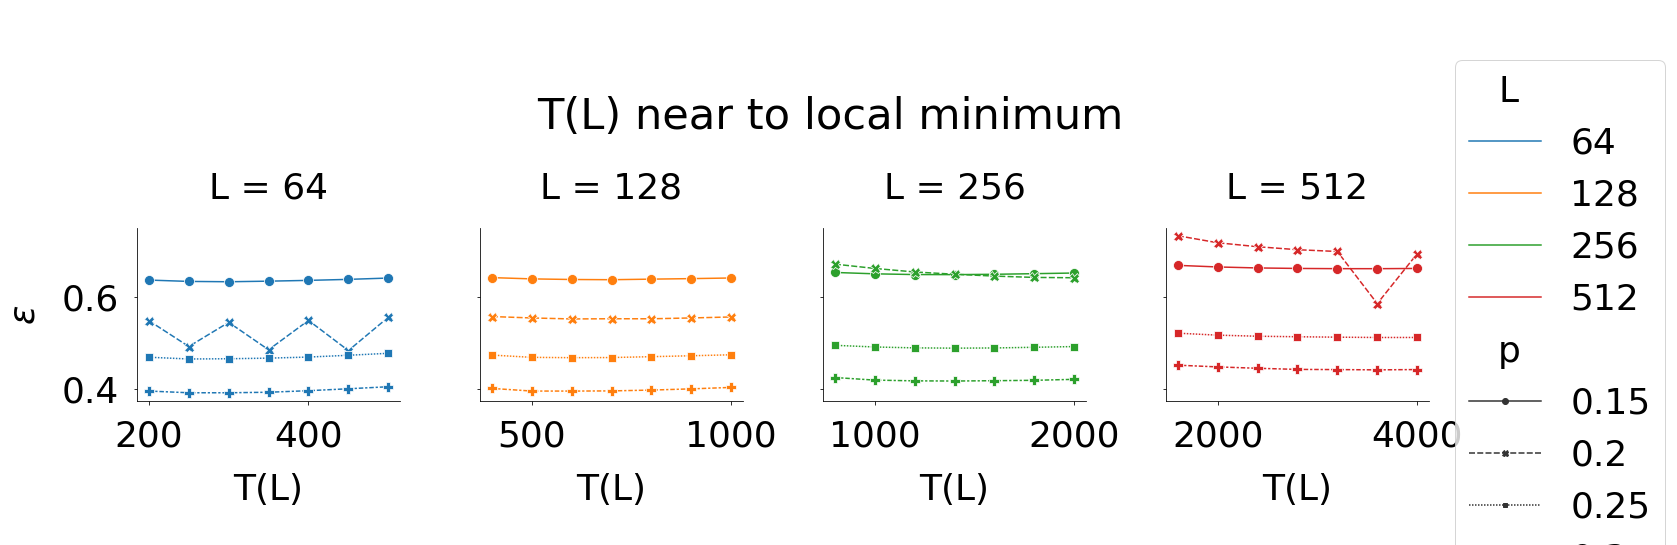

In [16]:
gamma = 2.60
t_scaling = 2

LS = [64, 128, 256, 512]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]
TS_local = [200, 250, 300, 350, 400, 450, 500]
TS_global = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1500, 1800, 1800 * 3 // 2, 1800*2, 1800*3, 1800*4, 1800*5, 1800*6]

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

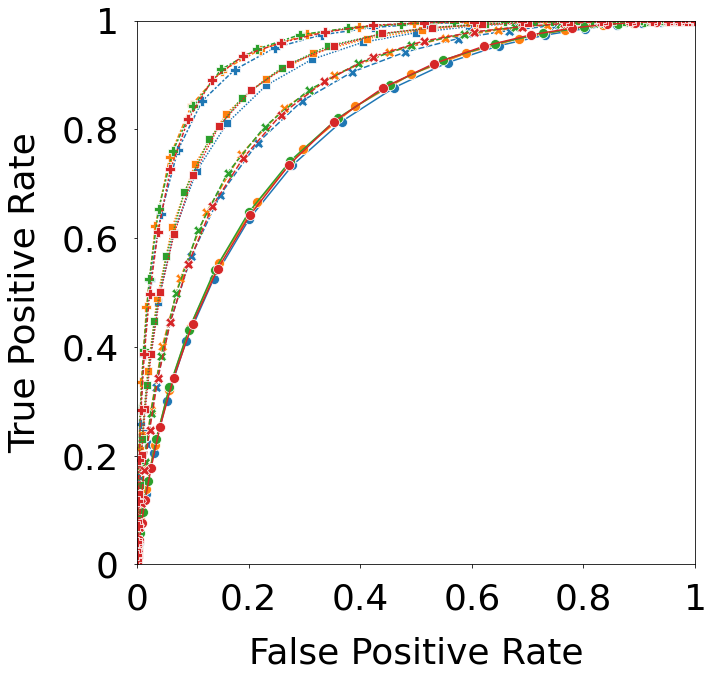

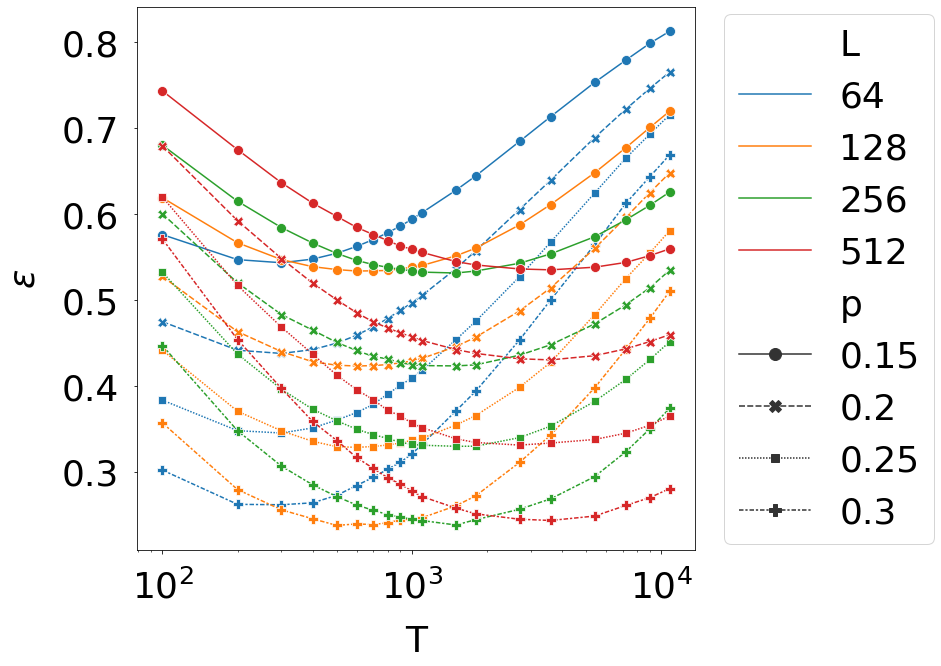

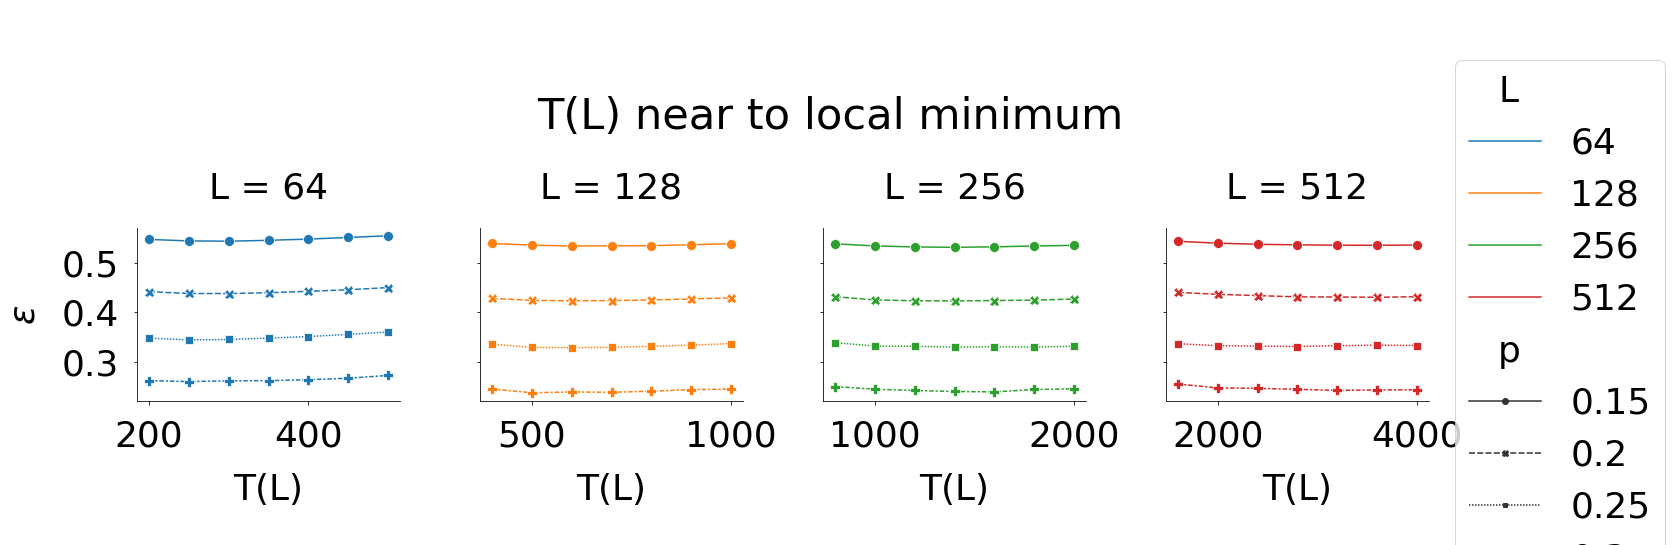

In [17]:
gamma = 2.67

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

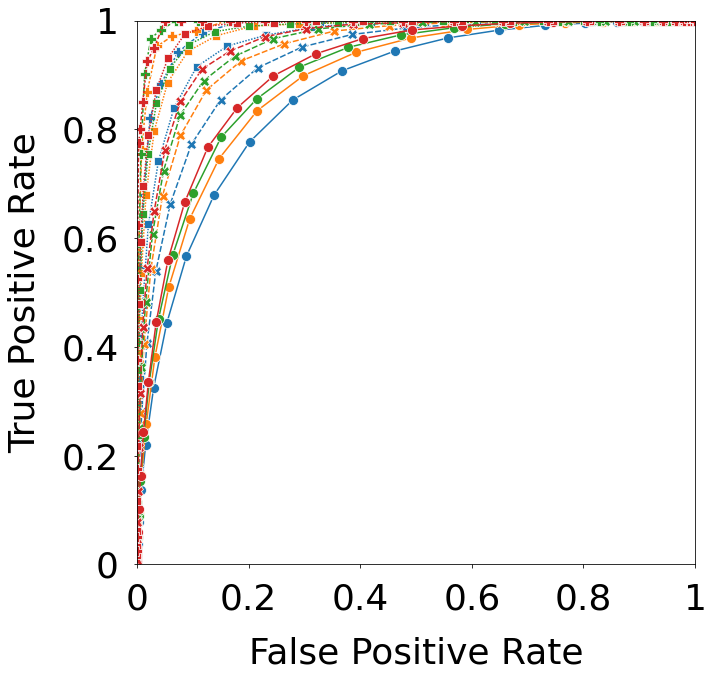

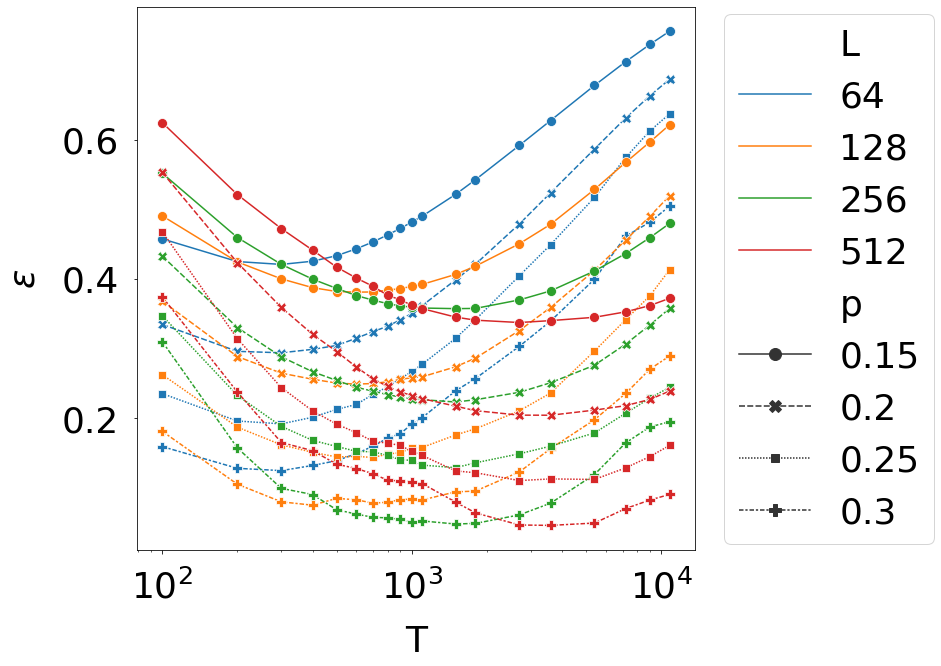

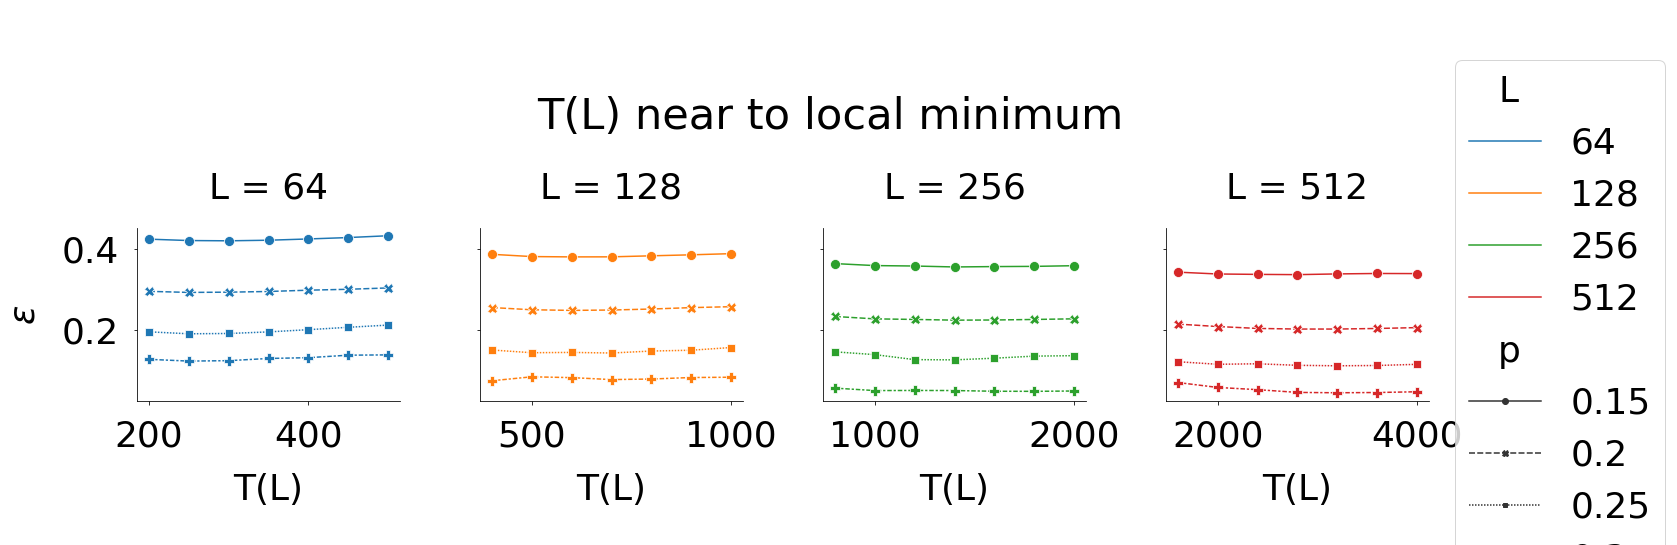

In [18]:
gamma = 2.75

plot_local_global(gamma, t_scaling, LS, PERCENTS_ETA, TS_local, TS_global, "rand")

In [19]:
gamma = 2.66

local_aucs = []

for i, L in enumerate(LS):
    TS_local_scaled = [int(t_scaling**i * t) for t in TS_local]
    auc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, [L], TS_local_scaled, "rand", njobs=7)
    local_aucs.append(auc_curve)

local_auc_curves = pd.concat(local_aucs)

local_auc_curves = local_auc_curves.reset_index()
local_auc_curves.loc[list(local_auc_curves.groupby(["L", "model", "p"])["eps"].idxmin())]

,index,L,ETA,A,model,results,eps,fpr,tpr,T,p,gamma
20,20,64,9561,0.997780,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.50113,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",450,0.15,2.66
21,21,64,12748,0.997780,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.37378,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",450,0.20,2.66
26,26,64,15935,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.29760,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",500,0.25,2.66
27,27,64,19123,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.15478,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",500,0.30,2.66
52,24,128,60432,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.55697,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9e-05, 9e-05, 9...",1000,0.15,2.66
53,25,128,80576,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.44981,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000,0.20,2.66
50,22,128,100720,0.998890,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.36005,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",900,0.25,2.66
55,27,128,120864,0.999000,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.24746,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1000,0.30,2.66
80,24,256,381952,0.999500,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-0...",0.62965,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000,0.15,2.66
81,25,256,509270,0.999500,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-0...",0.52037,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2000,0.20,2.66


## Best T(L) by fixed $L$ and $p$

In [20]:
gamma = 2.68

roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA, LS, TS, "rand", njobs=7)
roc_curve.loc[roc_curve.groupby(["L", "model", "p"])["eps"].idxmin()]

,L,ETA,A,model,results,eps,fpr,tpr,T,p,gamma
8,64,10390,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.52942,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[3e-05, 4e-05, 5e-05, 8e-05, 0.00012, 0.00017,...",300,0.15,2.68
9,64,13854,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.42195,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[5e-05, 8e-05, 0.00011, 0.00019, 0.0003, 0.000...",300,0.20,2.68
10,64,17318,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.32457,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00016, 0.00023, 0.00031, 0.00055, 0.00078, ...",300,0.25,2.68
11,64,20781,0.996672,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, ...",0.24022,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-05, 1...","[0.00052, 0.00078, 0.00104, 0.00181, 0.00259, ...",300,0.30,2.68
96,128,66590,0.998335,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.51595,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[2e-05, 2e-05, 2e-05, 3e-05, 8e-05, 0.0001, 0....",600,0.15,2.68
93,128,88787,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.40274,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[4e-05, 4e-05, 4e-05, 4e-05, 8e-05, 0.00024, 0...",500,0.20,2.68
98,128,110984,0.998335,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.30700,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[0.00011, 0.00011, 0.00011, 0.00022, 0.00054, ...",600,0.25,2.68
95,128,133181,0.998002,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e...",0.21289,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1e-05, 1e-...","[0.0, 0.0, 0.0, 0.0, 0.00034, 0.00101, 0.00168...",500,0.30,2.68
196,256,426750,0.999334,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.51329,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2e-05, 2e-05, 2e-05, 2e-05, 2e-05, 5e-05, 7e-...",1500,0.15,2.68
205,256,569001,0.999630,rand,"([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.41167,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6e-05, 6e-05, 0.00012, 0.00012, 0.00023, 0.00...",2700,0.20,2.68


We can see that the optimal scaling grater 2. Our assumtution is $T(L) = 2.25^{\log_{2}\frac{L}{64}} \cdot 300$.

### Statistics for optimal $\gamma$ and $T(L)$

Statistically prove that we have chosen the optimal parameters.

In [21]:
LS = [64, 128, 256, 512]
TS = [300, int(300 * 2.25), int(300 * 2.25**2), int(300*2.25**3)]
gammas = [2.6, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.7]
PERCENTS_ETA = [0.15, 0.2, 0.25, 0.30]

args = []
add_t = []
add_p = []
add_gamma = []

for percent in PERCENTS_ETA:
    for gamma in gammas:
        for T, L in zip(TS, LS):
            ETA = int(L**gamma * percent)
            A = np.exp(-1. / T)
            args.append((L, ETA, A, "rand"))
            add_t.append(T)
            add_p.append(percent)
            add_gamma.append(gamma)

abel_heap.calculate_conditional_probability_parallel(args, K_BINS=200, use_cache=True, njobs=7)
auc_curve = abel_heap.calculate_roc_curve_parallel(args, K_BINS=200, use_cache=True, njobs=7)

auc_curve["p"] = add_p
auc_curve["T"] = add_t
auc_curve["gamma"] = add_gamma
auc_curve["fpr"] = auc_curve["results"].apply(lambda x: list(x[0]))
auc_curve["tpr"] = auc_curve["results"].apply(lambda x: list(x[1]))
auc_curve["eps"] = auc_curve["results"].apply(lambda x: np.min(x[0] + (1 - x[1]))) # fpr + (1 - tpr)

In [22]:
#var = auc_curve.groupby(["p", "gamma"])["eps"].var().groupby("gamma").mean().rename("var")
var = auc_curve.groupby(["p", "gamma"])["eps"].var().rename("var").reset_index()

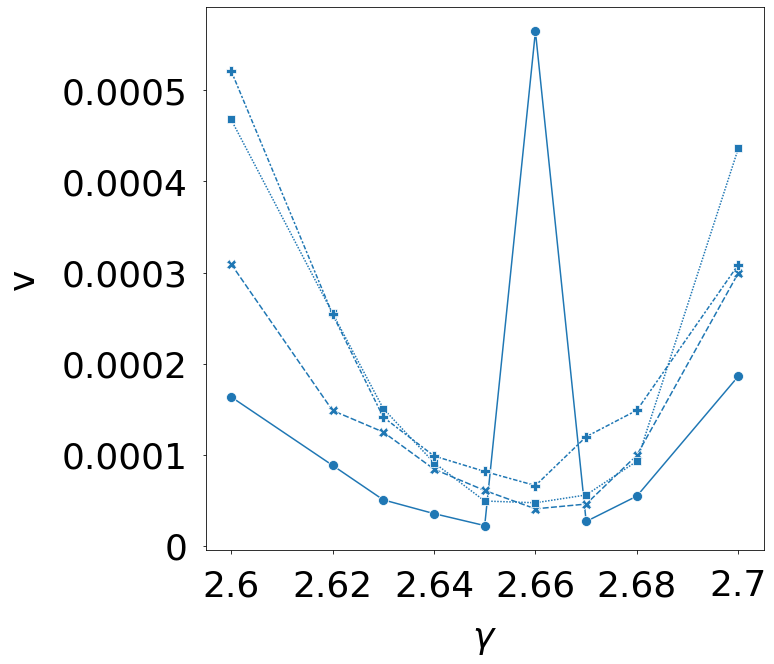

In [23]:
sns.lineplot(data=var, x="gamma", y="var", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("v")
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.yticks([0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005], [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005])
plt.xlabel("$\gamma$")
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression
from collections import defaultdict

gamma2coef = defaultdict(list)
absolute_coef = defaultdict(list)

for k, v in auc_curve.groupby(["gamma", "p"]):
    linreg = LinearRegression()
    y = v["eps"]
    X = np.array(v["T"]).reshape(y.shape[0], 1)
    linreg = linreg.fit(X, y)
    
    gamma2coef[k[0]].append(linreg.coef_[0])
    
    absolute_coef["gamma"].append(k[0])
    absolute_coef["p"].append(k[1])
    absolute_coef["absolute_coef"].append(np.abs(linreg.coef_[0]))
    
absolute_coef = pd.DataFrame(data=absolute_coef)

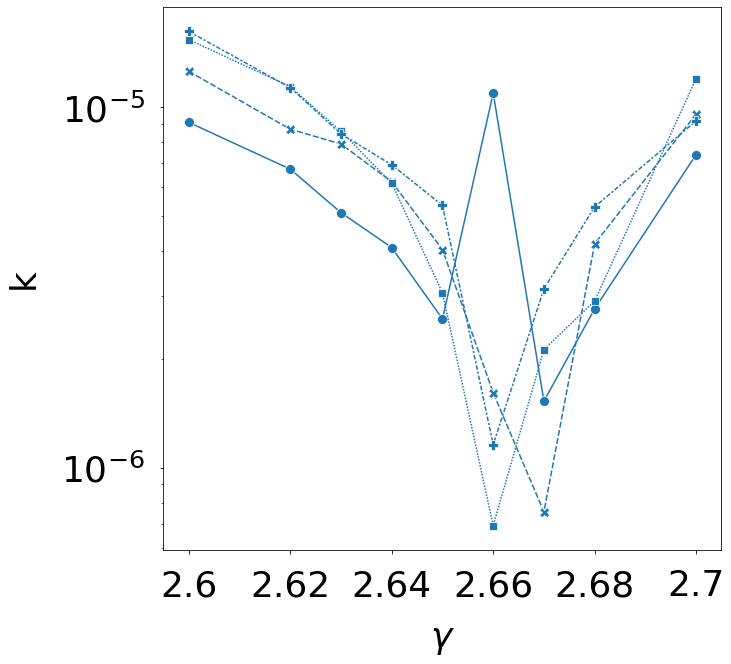

In [25]:
sns.lineplot(data=absolute_coef, x="gamma", y="absolute_coef", style="p", markers=True, palette="tab10", markersize=10, legend=False)
plt.ylabel("k")
plt.yscale("log")
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.xlabel("$\gamma$")
plt.show()

In [26]:
from shapely.geometry import Polygon
from IPython.display import display
from copy import deepcopy

def calculate_IoU_fixed_gamma(data):
    IoU = {}
    for p, by_p in data.groupby(["p"]):
        unions, intersects = None, None
        for L, by_p_l in by_p.groupby(["L"]):
            fpr = by_p_l["fpr"].iloc[0]
            tpr = by_p_l["tpr"].iloc[0]
            polygon = Polygon([(x, y) for x, y in zip(fpr, tpr)] + [(1, 0)])
            if unions is None:
                unions = deepcopy(polygon)
                intersects = deepcopy(polygon)
            else:
                intersects = intersects.intersection(polygon)
                unions = unions.union(polygon)
        
        IoU[p] = intersects.area / unions.area
        
    return IoU

def calculate_IoU(data):
    results = defaultdict(list)
    for gamma, by_gamma in data.groupby(["gamma"]):
        IoU_gamma = calculate_IoU_fixed_gamma(by_gamma)
        results["p"] += IoU_gamma.keys()
        results["IoU"] += IoU_gamma.values()
        results["gamma"] += [gamma] * len(IoU_gamma)
    return pd.DataFrame(data=results)

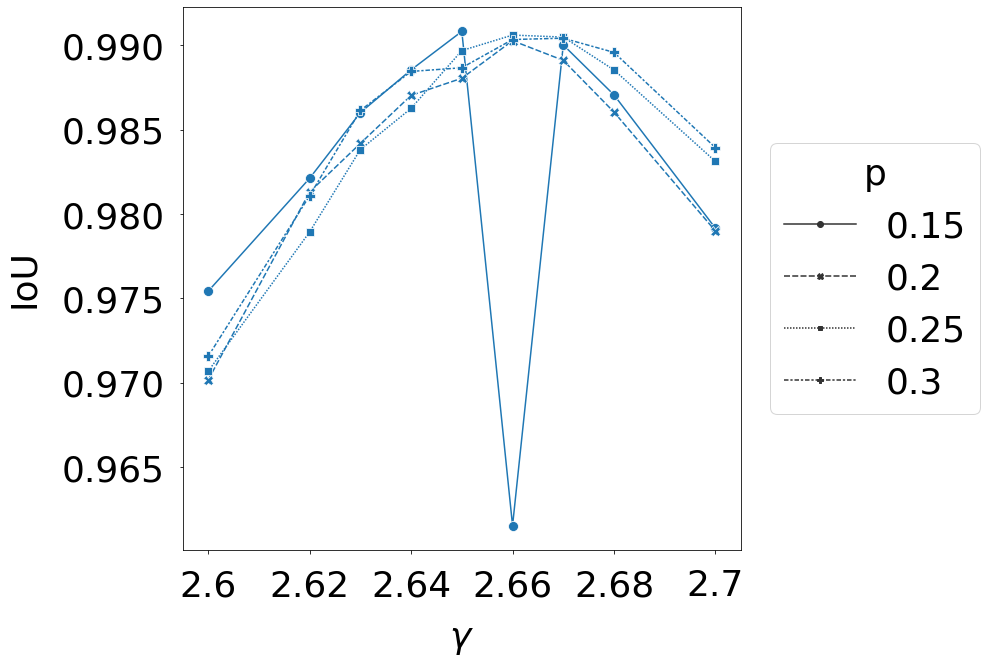

In [28]:
IoU = calculate_IoU(auc_curve)
sns.lineplot(data=IoU, x="gamma", y="IoU", style="p", markers=True, palette="tab10", markersize=10)
plt.xticks([2.60, 2.62, 2.64, 2.66, 2.68, 2.70], [2.60, 2.62, 2.64, 2.66, 2.68, 2.70])
plt.legend(bbox_to_anchor=[1.02, 0.5], loc='center left', title="p")
plt.xlabel("$\gamma$")
plt.show()

## Quality vs event rate

In [29]:
def calculate_event_rate(gamma, PERCENTS_ETA, LS, model):    
    event_rates = {
        "event_rate": [],
        "L": [],
        "p": [],
        "model": []
    }
    
    for L in LS:
        ETAs = []
        for percent in PERCENTS_ETA:
            ETAs.append(int(L**gamma * percent))
        count_events = abel_heap.calculate_events(L, ETAs, model)
        total_events = count_events[-1]
        count_events = count_events[:-1]
        
        count_events = list(map(lambda x: x / total_events, count_events))
        event_rates["event_rate"].extend(count_events)
        event_rates["L"].extend([L] * len(PERCENTS_ETA))
        event_rates["model"].extend([model] * len(PERCENTS_ETA))
        event_rates["p"].extend(PERCENTS_ETA)
    
    return pd.DataFrame(event_rates)

In [30]:
gamma = 2.67
PERCENTS_ETA_EXTENDED = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "rand", njobs=7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p", "ETA"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

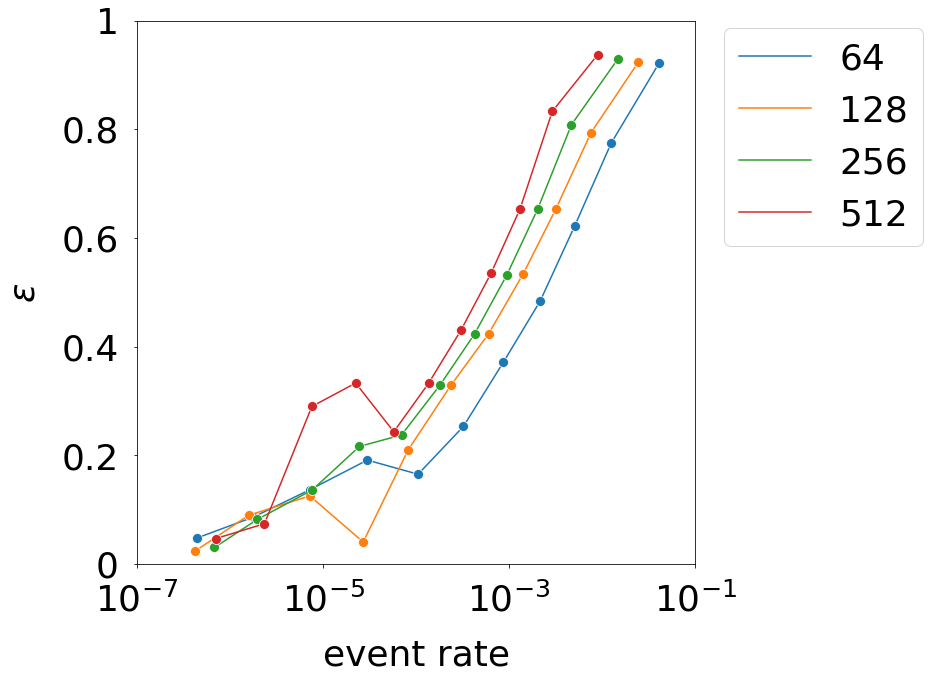

In [32]:
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", style="p", size="gamma", markers=True, palette="tab10", s=300)
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", s=300)
#sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", markersize=100)
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

#plt.title(f"Quality of predictions depending on event rate in Manna model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
plt.show()

In [36]:
gamma = 2.75
PERCENTS_ETA_EXTENDED = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]
roc_curve = calculate_roc_curve_gamma(gamma, PERCENTS_ETA_EXTENDED, LS, TS, "rand", njobs=7)
opt_metric = pd.DataFrame(roc_curve.groupby(["L", "model", "p", "ETA"])["eps"].min()).reset_index()
opt_metric["p"] = opt_metric["p"].astype(float)
event_rate = calculate_event_rate(gamma, PERCENTS_ETA_EXTENDED, LS, "rand")
opt_metric = pd.merge(opt_metric, event_rate, on=["L", "p", "model"], how="left")

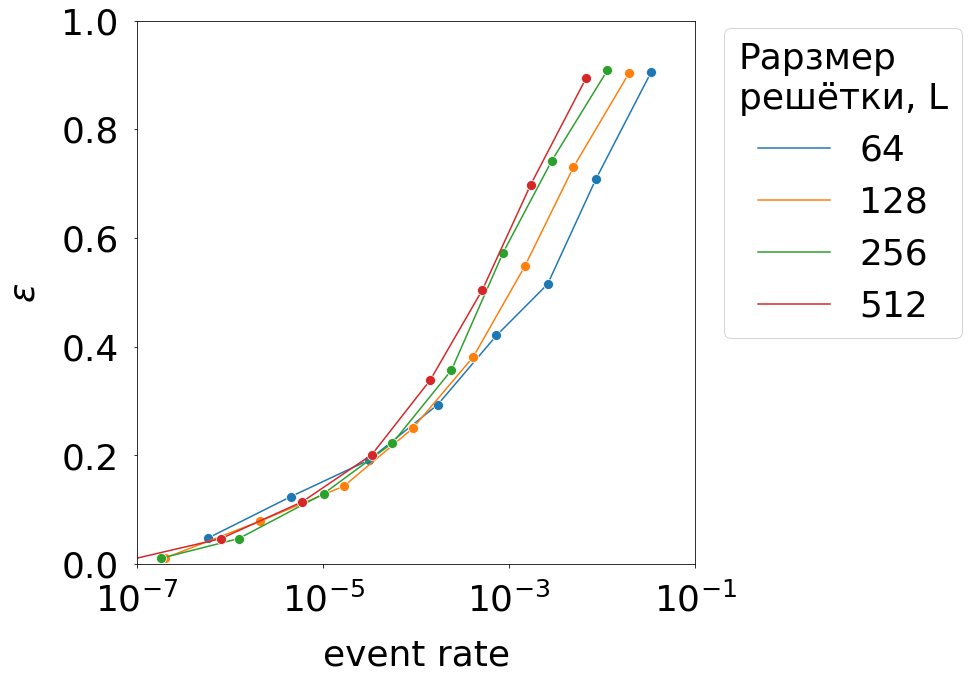

In [37]:
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", style="p", size="gamma", markers=True, palette="tab10", s=300)
#sns.scatterplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", s=300)
#sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", markers=True, palette="tab10", markersize=100)
sns.lineplot(data=opt_metric, x="event_rate", y="eps", hue="L", marker="o", palette="tab10", markersize=10)

#plt.title(f"Quality of predictions depending on event rate in Manna model")
plt.xlabel("event rate")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
plt.xlim([1e-7, 1e-1])
legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
legend.set_title("Рарзмер\nрешётки, L") 
plt.show()

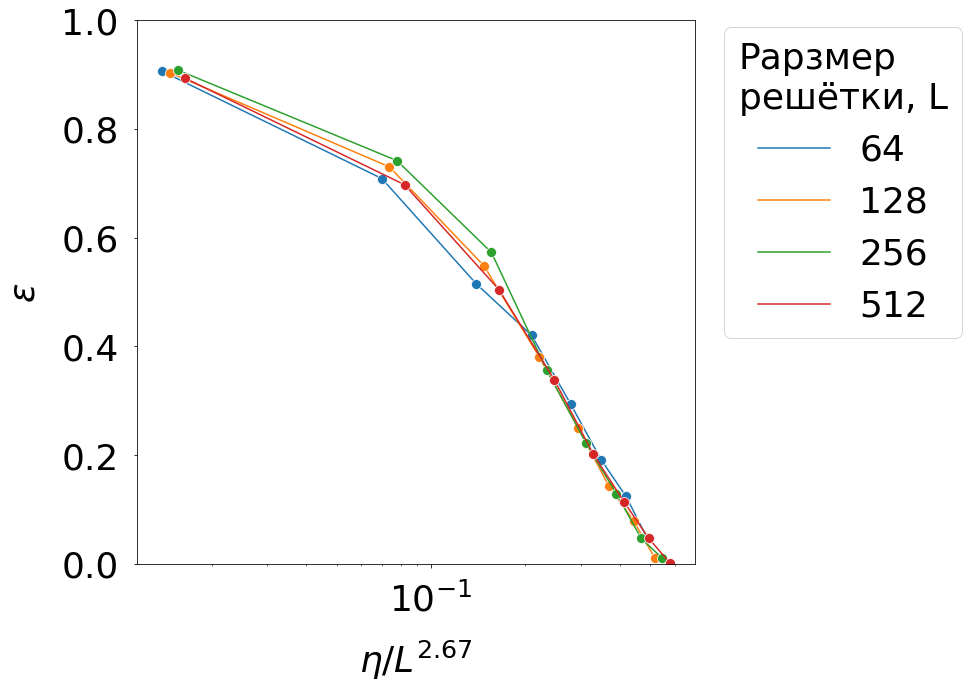

In [38]:
opt_metric["normalized_s"] = opt_metric["ETA"] / opt_metric["L"]**2.67

sns.lineplot(data=opt_metric, x="normalized_s", y="eps", hue="L", marker="o", palette="tab10", markersize=10)
plt.xlabel(r"$\eta / L^{2.67}$")
plt.ylabel("$\epsilon$")
plt.xscale("log")
plt.ylim([0, 1])
#plt.xlim([1e-7, 1e-1])
#plt.ylim([0.3, 1])
#plt.xlim([1e-6, 1e-1])
legend = plt.legend(bbox_to_anchor=(1.02,1.02), loc="upper left", markerscale=2)
legend.set_title("Рарзмер\nрешётки, L") 
plt.show()